# Final Assignment {-}

### Team details {-}
Add the names of all team members and a short description of each member's contributions.   
- TEAM MEMBER 1 = Femke Bergen - Part 1 & 3
- TEAM MEMBER 2 = Noelle Cicilia - Part 1
- TEAM MEMBER 3 = Kasper Raijmann - Part 4
- TEAM MEMBER 4 = Joep Sterk  - Part 4
- TEAM MEMBER 5 = Jens Bongaerts - Part 2
- TEAM MEMBER 6 = Jarno Smit - Part 2 & 3

## 1. Simple networks (20 points) {-}

In [203]:
import os
import statistics
import time
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from preamble import *
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense, Dropout
from keras import regularizers
print("Using Keras",keras.__version__)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences

Using Keras 2.2.5


In [4]:
#copied from kaggle post 'IMDB setiments' by Arunava
def shuffle(X, y):
    perm = np.random.permutation(len(X))
    X = X[perm]
    y = y[perm]
    return X, y

In [3]:
#copied from kaggle post 'IMDB setiments' by Arunava
# label 0 --> negative, label 1 --> positive
def load_imdb_dataset():
    imdb_path = os.path.join('imdb-movie-reviews-dataset/aclImdb/aclImdb')

    # Load the dataset
    train_texts = []
    train_labels = []
    test_texts = []
    test_labels = []
    for dset in ['train', 'test']:
        for cat in ['pos', 'neg']:
            dset_path = os.path.join(imdb_path, dset, cat)
            for fname in sorted(os.listdir(dset_path)):
                if fname.endswith('.txt'):
                    with open(os.path.join(dset_path, fname), encoding = 'utf-8') as f:
                        if dset == 'train': train_texts.append(f.read())
                        else: test_texts.append(f.read())
                    label = 0 if cat == 'neg' else 1
                    if dset == 'train': train_labels.append(label)
                    else: test_labels.append(label)

    # Converting to np.array
    train_texts = np.array(train_texts)
    train_labels = np.array(train_labels)
    test_texts = np.array(test_texts)
    test_labels = np.array(test_labels)

    # Shuffle the dataset
    train_texts, train_labels = shuffle(train_texts, train_labels)
    test_texts, test_labels = shuffle(test_texts, test_labels)

    # Return the dataset
    return train_texts, train_labels, test_texts, test_labels

In [204]:
#copied from kaggle post 'IMDB setiments' by Arunava
trX, train_Y, ttX, test_Y = load_imdb_dataset()

In [7]:
#positive and negative example of the reviews --> X is still text
print(train_Y[0], '==========', trX[0])
print('')
print(train_Y[1], '==========', trX[1])

0 ========== The Perfectly Stupid Weapon. I think the guys dancing at the beginning of one of Steven Segal's movies was intented to mock Jeff doing his forms to dance music at the beginning of this stupid movie. The plot is predictable, the fights were fair and Jeff acts about as well as the sofa he beats with some sort of weapon in one scene.

0 ========== In this short an urban man and his wife have their weird lives set akimbo when the man takes to wearing an old red pants suit of his mother in law's.<br /><br />I kept watching this hoping that I could see why it had been made, or why the other reviewers found it funny. For me it was a total waste of time.<br /><br />Not everyone's tastes are the same but this was clearly not to mine.


In [11]:
#vectorize the text-data (X-data) with tfidf vectorize method
vectorizer = TfidfVectorizer(min_df=2)
x_train = vectorizer.fit_transform(trX)
x_test = vectorizer.transform(ttX)

#select 10.000 best words to use as features
selector = SelectKBest(f_classif, k=min(10000, x_train.shape[1]))
selector.fit(x_train, train_Y)

#create final train and test data
X_train = selector.transform(x_train).astype('float32').toarray()
X_test = selector.transform(x_test).astype('float32').toarray()

In [8]:
def make_model(n_hidden, hidden_size=32, input_size=16, optimizer="adam", loss='binary_crossentropy',
               regularizer = None, dropout=False, dropout_rate=0.5,
               embedding = False, embedding_layer = 0, input_shape=(10000,)):
    """
    Makes a sequential model with n_hidden layers that have size hidden_size
    returns compiled the model with customizable optimizer, loss function, regularization, dropout and embedding.
    """
    #create model
    model = models.Sequential()
    if embedding == True and embedding_layer == 0:
        print("Please specify embedding_layer parameter")
    elif embedding == True:
        model.add(embedding_layer)
        model.add(Flatten())
    #add input layer
    model.add(Dense(input_size, kernel_regularizer=regularizer, activation='relu', input_shape=input_shape))
    #add hidden layers
    for i in range(n_hidden):
        model.add(Dense(hidden_size, kernel_regularizer=regularizer, activation='relu'))
        if dropout:
            model.add(Dropout(dropout_rate))
    #add output layer
    model.add(Dense(1, activation='sigmoid')) #sigmoid for binary classification
    #return compiled model
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    return model

In [9]:
#mocel = model
def NN_performance(model, Xtrain, Ytrain, Xval, Yval, n_epochs=20): 
    """Takes in a model, train data and validation data and a customizable number of epochs.
     Returns a dictionary with the maximum validation accuracy and the minimum validation loss with 
     their corresponding number of epochs and fit time."""
    start = time.process_time()
    history = model.fit(Xtrain, Ytrain,
                    epochs=n_epochs, batch_size=512, verbose=0,
                    validation_data=(Xval, Yval))
    
    train_time = time.process_time() - start
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    return {'Max_val_acc' : max(val_acc), 
            'Max_val_acc_epochs' : np.argmax(val_acc)+1, 
            'Min_val_loss' : min(val_loss), 
            'Min_val_loss_epochs' : np.argmin(val_loss)+1,
            'train_time':train_time}

In [11]:
def NN_performance_df(Xtrain, Ytrain, max_hidden = 3, n_epochs=20):
    """Takes training data, customizable number of midden layers to test for and a customizable number of epochs to test for.
    Returns a dataframe with multi-index number of hidden layers (1,2,3) & hidden layer size (16, 32, 64, 128)
    and their corresponding outcome of NN_performance function"""    
    #split the data
    x_val, partial_x_train = Xtrain[:10000], Xtrain[10000:]
    y_val, partial_y_train = Ytrain[:10000], Ytrain[10000:]
    
    performance_dict = {}
    
    #loop over different hyperparameter options
    for nhid in tqdm_notebook(range(max_hidden)):
        for hid_size in [4, 8, 16, 32, 64]:
            model = make_model(nhid+1, hidden_size=hid_size, optimizer='rmsprop', loss='binary_crossentropy')
            #fill performance dict with validation accuracy and loss scores + corresponding epochs
            performance_dict[(nhid+1, hid_size)] = NN_performance(model, partial_x_train, partial_y_train, x_val, y_val)   
    
    performance_df = pd.DataFrame.from_dict(performance_dict, orient='index')
    return performance_df

In [12]:
def plot_epochs(epochs, y_1, y_2, label_1, label_2, title, y_title):
    """epochs: list/array with all the epochs
    y_1: list/array with scoring per epoch (e.g. (validation) loss/accuracy of original/regularized model
    y_2: same options as y_1)
    --> y_1 and y_2 should have the same metrics (either loss or acuracy)
    label_1: string, what you plot in y_1
    label_2: string, what you plot in y_2
    title: string
    """
    #PLOT epochs vs loss or acuracy
    # "bo" is for "blue dot"
    plt.plot(epochs, y_1, 'bo', label=label_1)
    # b is for "solid blue line"
    plt.plot(epochs, y_2, 'b', label=label_2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.legend()
    plt.show()

In [13]:
def scores(model, epochs, x_train, y_train, x_val, y_val):
    """takes a NN model, number of epochs and train and validation data. 
    Returns train and validation accuracy and loss and a list with epochs"""
    history = model.fit(x_train, y_train,
                    epochs=epochs, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val))
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)
    return history, train_acc, val_acc, train_loss, val_loss, epochs  

In [22]:
#print the 
NN_performance_df(X_train, train_Y)

W1118 19:52:14.772710  8484 deprecation.py:323] From C:\Users\jarno\Anaconda3\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Number of hidden layers, Number of nodes in hidden layers


Max_val_acc  Max_val_acc_epochs  Min_val_loss  Min_val_loss_epochs  \
1 4          0.91                  14          0.22                   14   
  8          0.91                  14          0.22                   13   
  16         0.91                  14          0.24                   14   
  32         0.91                   9          0.22                    9   
  64         0.91                   9          0.22                    8   
2 4          0.91                  18          0.22                   17   
  8          0.91                  14          0.22                   14   
  16         0.91                   5          0.23                    7   
  32         0.91                   4          0.23                    4   
  64         0.91                   4          0.22                    4   
3 4          0.91                  14          0.24                   15   
  8          0.91                   8          0.25                    8   
  16         0.91                   5          0.22                    5   
  32         0.91                   3          0.23                    4   
  64         0.91                   3          0.22                    3   

      train_time  
1 4        59.19  
  8        59.48  
  16       58.66  
  32       61.14  
  64       59.16  
2 4        57.66  
  8        63.23  
  16       63.08  
  32       61.39  
  64       59.81  
3 4        58.89  
  8        62.02  
  16       60.53  
  32       61.02  
  64       59.58

In [23]:
# split train data in train and validation data
x_val, partial_x_train = X_train[:10000], X_train[10000:]
y_val, partial_y_train = train_Y[:10000], train_Y[10000:]

In [24]:
# almost balanced train & validation sets
print((y_val == 0).sum())
print((y_val == 1).sum())

5004
4996


In [25]:
#some global variables
nr_of_epochs = 40
n_hidden = 1
hidden_size = 8

In [26]:
# make model with best hyperparameter settings, judged from NN_performance dataframe
original_model = make_model(n_hidden=n_hidden, hidden_size=hidden_size)

In [27]:
history_original, train_acc_original, val_acc_original, train_loss_original, val_loss_original, epochs = \
scores(original_model, nr_of_epochs, partial_x_train, partial_y_train, x_val, y_val)

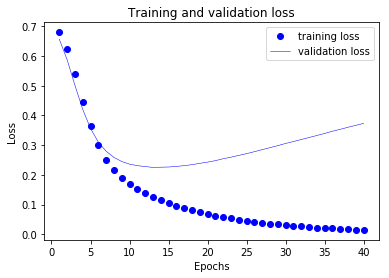

In [28]:
#PLOT epochs vs loss
plot_epochs(epochs, train_loss_original, val_loss_original, 
            'training loss', 'validation loss', 
            'Training and validation loss', 'Loss')

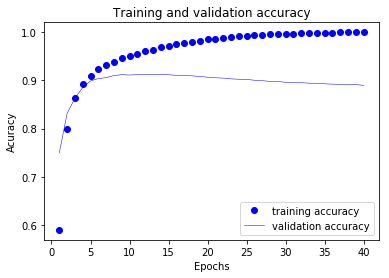

In [29]:
#PLOT epochs vs accuracy
plot_epochs(epochs, train_acc_original, val_acc_original, 
            'training accuracy', 'validation accuracy', 
            'Training and validation accuracy', 'Acuracy')

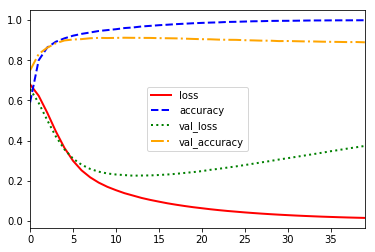

In [30]:
#plot epochs vs accuracy and loss
pd.DataFrame(history_original.history).plot(color=['red', 'blue', 'green', 'orange'], linewidth=2);

In [31]:
print('max validation accuracy + epochs', max(val_acc_original), np.argmax(val_acc_original))
print('min validation loss + epochs', min(val_loss_original), np.argmin(val_loss_original))
print('max train accuracy', max(train_acc_original))
print('min train loss', min(train_loss_original))

max validation accuracy + epochs 0.9123 11
min validation loss + epochs 0.22506722526550293 12
max train accuracy 0.9994
min train loss 0.01470247532526652


## Evaluate network

The chosen network is a neural network with 1 hidden layer. The output layer has one node and the sigmoid activation function, because it is a binary classification problem. The input layer has 16 nodes. We started with 16 nodes as input, than we evaluated the best hyperparameters for hidden layer size, number of hidden layers and loss function. When we trained a model with an input layer of 32 nodes and with the hyperparameter settings that were best for the with 32 nodes input model, we yielded slightly better results (improvement less than 0.01) for both the loss and the accuracy. When we tried the same for a model with an input layer with 64 nodes, we got worse results as for the two models described above. Thus, we concluded that we should use an input layer with 32 nodes and ran the hyperparameter gidsearch (see next paragraph) for a network with 32 input nodes. However, we noticed that this network costs +/- 7 seconds longer to train, which is an increase in fit time of about 25%. Because of efficiency reasons, we chose to use the network with 16 nodes in the input layer. 

As loss function we chose binary cross-entropy because we are facing a binary classification task. Binary cross-entropy is the correct loss function to deal with such a problem.

For the evaluation of the hyperparameter settings, we created a grid search ourselves (without cross validation) to determine the best number of hidden layers and hidden layer size. The results for the different hyperparameter settings differ not much. We chose 1 hidden layer with 8 nodes, because this was the least complex network that yielded the best results. Other configurations of the network yielded the same results, but were more complex or more time costly (although the differences were fairly small). Our training data set has 25.000 entries, which should be big enough to train a deeper network, but considering the results of the grid search, it is not necesarry to use a deeper network. The optimal number of epochs for this network is 13. Also, a deeper network might be more prone to overfitting. 

## Evaluate network performance

In [33]:
original_model.fit(X_train, train_Y, epochs=13, batch_size=512, verbose=0)
result = original_model.evaluate(X_test, test_Y, verbose=0)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

Loss: 0.8879, Accuracy:  0.8273


The network performs quite well on the test set when we look at the accuracy. Without regularization, the network scores 0.83 accuracy on the test set. The model is still slightly overfitting, since the validation accuracy was 0.92, which is 0.09 higher than the test accuracy and the training accuracy was almost 1 (0.999). 

# Regularizing

In [34]:
#L1 regularizing
L1_model = make_model(n_hidden=n_hidden, hidden_size=hidden_size, input_size=16, regularizer=regularizers.l1(0.0001))

history_L1, train_acc_L1, val_acc_L1, train_loss_L1, val_loss_L1, epochs = \
scores(L1_model, nr_of_epochs, partial_x_train, partial_y_train, x_val, y_val)

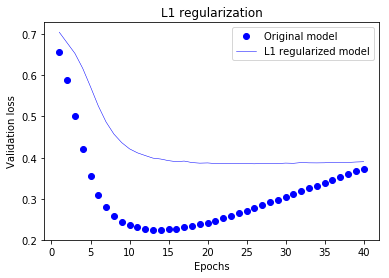

original max validation accuracy:  0.9123 
original min validation loss:  0.22506722526550293

regularized max validation accuracy:  0.8813 
regularized min validation loss:  0.3852128067970276

regularized max train accuracy:  0.9397333 
regularized min train loss:  0.2695025644143422


In [35]:
plot_epochs(epochs, val_loss_original, val_loss_L1, 
            'Original model', 'L1 regularized model', 
            'L1 regularization', 'Validation loss')

print('original max validation accuracy: ', max(val_acc_original), '\noriginal min validation loss: ', min(val_loss_original))
print('\nregularized max validation accuracy: ', max(val_acc_L1), '\nregularized min validation loss: ', min(val_loss_L1))
print('\nregularized max train accuracy: ', max(train_acc_L1), '\nregularized min train loss: ', min(train_loss_L1))

In [36]:
## L2 regularizing
L2_model = make_model(n_hidden=n_hidden, hidden_size=hidden_size, input_size=16, regularizer=regularizers.l2(0.0001))

history_L2, train_acc_L2, val_acc_L2, train_loss_L2, val_loss_L2, epochs = \
scores(L2_model, nr_of_epochs, partial_x_train, partial_y_train, x_val, y_val)

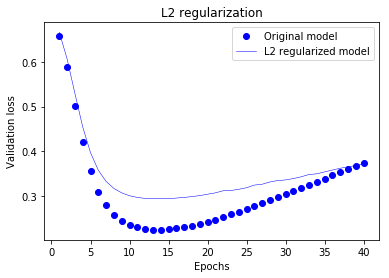

original max validation accuracy:  0.9123 
original min validation loss:  0.22506722526550293

regularized max validation accuracy:  0.9042 
regularized min validation loss:  0.29451590118408205

regularized max train accuracy:  0.993 
regularized min train loss:  0.10207615117232005


In [37]:
plot_epochs(epochs, val_loss_original, val_loss_L2, 
            'Original model', 'L2 regularized model', 
            'L2 regularization', 'Validation loss')

print('original max validation accuracy: ', max(val_acc_original), '\noriginal min validation loss: ', min(val_loss_original))
print('\nregularized max validation accuracy: ', max(val_acc_L2), '\nregularized min validation loss: ', min(val_loss_L2))
print('\nregularized max train accuracy: ', max(train_acc_L2), '\nregularized min train loss: ', min(train_loss_L2))

### Evaluation of L1 and L2 regularization

In [38]:
# Evaluating L2, because L2 performed better on the validation set than L1
L2_model = make_model(n_hidden=n_hidden, hidden_size=hidden_size, input_size=16, regularizer=regularizers.l2(0.0001))
L2_model.fit(X_train, train_Y, epochs=13, batch_size=512, verbose=0)
L2_result = L2_model.evaluate(X_test, test_Y, verbose=0)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*L2_result))

Loss: 0.3386, Accuracy:  0.8779


For regularization, you can take a smaller network, you can use L1 or L2 regularization, or you could use dropout layers. We didn't choose to test for a smaller network, since the network that we chose to use is already very small. 

Here we will discuss the plots above that use L1 and L2 regularization.

The plots above show that the original model starts overfitting after +/- 10 epochs. 
L1 regularization doesn't seem start overfitting within 40 epochs. However, it also doesn't reach a validation loss as low as the original model within 40 epochs. The printed maximum accuracy isn't as high for the regularized model as for the original model.
L2 regularization starts overfitting around 15 epochs. However, it overfits significantly more slowly than the original model. In addition to this, it's accuracy is not as high as the accuracy of the origical model, but it is higher than with the L1 regularization. 

When we evaluate our L2 regularized model on the testset it has an accuracy of 0.88, which is an improvement compared to the original model (0.84). However, the model is still overfitting, since the train accuracy of the L2 regularized model is 0.99.

### Dropout model

In [39]:
dpt_model = make_model(n_hidden=n_hidden, hidden_size=hidden_size, input_size=16, optimizer="adam", loss='binary_crossentropy', 
               regularizer = None, dropout=True, dropout_rate=0.3)

history_dpt, train_acc_dpt, val_acc_dpt, train_loss_dpt, val_loss_dpt, epochs = \
scores(dpt_model, nr_of_epochs, partial_x_train, partial_y_train, x_val, y_val)

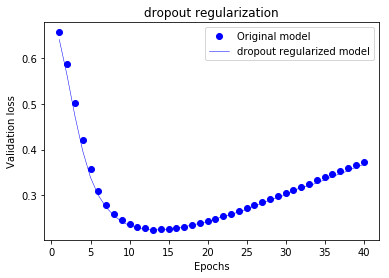

original max validation accuracy:  0.9123 
original min validation loss:  0.22506722526550293

dpt-regularized max validation accuracy:  0.9123 
dpt-regularized min validation loss:  0.22423196573257445

dpt-regularized max train accuracy:  0.993 
dpt-regularized min train loss:  0.10207615117232005


In [40]:
plot_epochs(epochs, val_loss_original, val_loss_dpt, 
            'Original model', 'dropout regularized model', 
            'dropout regularization', 'Validation loss')

print('original max validation accuracy: ', max(val_acc_original), '\noriginal min validation loss: ', min(val_loss_original))
print('\ndpt-regularized max validation accuracy: ', max(val_acc_dpt), '\ndpt-regularized min validation loss: ', min(val_loss_dpt))
print('\ndpt-regularized max train accuracy: ', max(train_acc_L2), '\ndpt-regularized min train loss: ', min(train_loss_L2))

### Evaluation drop-out model

In [41]:
dpt_model.fit(X_train, train_Y, epochs=17, batch_size=512, verbose=0)
result = dpt_model.evaluate(X_test, test_Y, verbose=0)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

Loss: 0.6818, Accuracy:  0.8364


The model with drop-out layers performs better on the validation set than the original model and also starts overfitting more slowly. Thus, the performance of the drop-out model seems to perform better than de original model. However, it performs worse on the testset with an accuracy of 0.82 (compared to 0.84). The high training score of 0.99 indicates that the model still overfits. 

### Combined L2 & dropout

In [42]:
dpt_L2_model = make_model(n_hidden=n_hidden, hidden_size=hidden_size, input_size=16, optimizer="adam", loss='binary_crossentropy', 
               regularizer=regularizers.l2(0.00001), dropout=True, dropout_rate=0.5)

history_L2_dpt, train_acc_L2_dpt, val_acc_L2_dpt, train_loss_L2_dpt, val_loss_L2_dpt, epochs = \
scores(dpt_L2_model, nr_of_epochs, partial_x_train, partial_y_train, x_val, y_val)

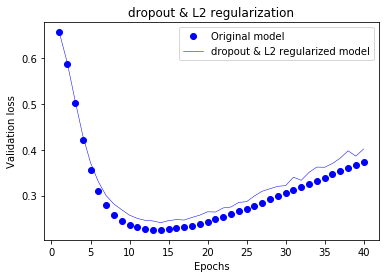

original max validation accuracy:  0.9123 
original min validation loss:  0.22506722526550293

dpt-regularized max validation accuracy:  0.9105 
dpt-regularized min validation loss:  0.2407931944847107

regularized max train accuracy:  0.98233336 
regularized min train loss:  0.09836721007823944


In [43]:
plot_epochs(epochs, val_loss_original, val_loss_L2_dpt, 
            'Original model', 'dropout & L2 regularized model', 
            'dropout & L2 regularization', 'Validation loss')

print('original max validation accuracy: ', max(val_acc_original), '\noriginal min validation loss: ', min(val_loss_original))
print('\ndpt-regularized max validation accuracy: ', max(val_acc_L2_dpt), '\ndpt-regularized min validation loss: ', min(val_loss_L2_dpt))
print('\nregularized max train accuracy: ', max(train_acc_L2_dpt), '\nregularized min train loss: ', min(train_loss_L2_dpt))

### dpt & L2 model evaluation

In [44]:
dpt_L2_model.fit(X_train, train_Y, epochs=17, batch_size=512, verbose=0)
result = dpt_L2_model.evaluate(X_test, test_Y, verbose=0)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

Loss: 0.5906, Accuracy:  0.8468


The dropout and L2 regularized model performs slightly better than the original model with the chosen dropout rate and learning rate for L2. Adding the dropout layers to our L2 regularized model does not improve our model, but decreases its performance. The L2 regularized model without dropout yields the best results until now.  

# Try to further improve performance 
We decided to try for different optimizerd and learning rates. At first, we also wanted to compare different dropout rates, but since we concluded that adding dropout does not improve the performance of the original model or the regularized model, but instead decreases the performance, we decided to not add dropout. 

In [45]:
optimizers = ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam']
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]
#dropout_rates = [0.2, 0.35, 0.5]

In [46]:
opt_dict = {}
for optimizer in optimizers:
    model = make_model(n_hidden, 
                           hidden_size=hidden_size, 
                           optimizer=optimizer, 
                           loss='binary_crossentropy')
    opt_dict[optimizer] = NN_performance(model, partial_x_train, partial_y_train, x_val, y_val)      

In [47]:
opt_df = pd.DataFrame.from_dict(opt_dict, orient='index')    
        
opt_df  

,Max_val_acc,Max_val_acc_epochs,Min_val_loss,Min_val_loss_epochs,train_time
adadelta,0.51,20,0.69,20,58.06
adagrad,0.87,20,0.58,20,58.53
adam,0.91,12,0.22,13,57.66
adamax,0.91,20,0.24,20,57.92
nadam,0.91,11,0.22,11,63.59
rmsprop,0.91,14,0.22,14,59.66
sgd,0.59,20,0.69,20,56.11


Based on the dataframe above, we decided to only do a gridsearch on the optimizers with a performance (accuracy) on the validation set of 0.9 or higher.

In [48]:
optimizers = ['adam', 'rmsprop', 'adamax', 'nadam']

In [49]:
def manual_tuning(x_train, y_train, x_val, y_val, n_epochs=20, optimizers=['adam']):
    performance_dict = {}
    for optimizer in tqdm_notebook(optimizers):
        for learning_rate in learning_rates:
            model = make_model(n_hidden, 
                               hidden_size=hidden_size, 
                               optimizer=optimizer, 
                               loss='binary_crossentropy',  
                               regularizer=regularizers.l2(learning_rate))
            #fill performance dict with validation accuracy and loss scores + corresponding epochs
            performance_dict[(optimizer, learning_rate)] = NN_performance(model, x_train, y_train, x_val, y_val)
    performance_df = pd.DataFrame.from_dict(performance_dict, orient='index')
    return performance_df

In [205]:
df_manual_tuning = manual_tuning(partial_x_train, partial_y_train, x_val, y_val, optimizers=optimizers)

In [51]:
df_manual_tuning

Max_val_acc  Max_val_acc_epochs  Min_val_loss  \
adam    1.00e-06         0.91                  12          0.23   
        1.00e-05         0.91                  11          0.24   
        1.00e-04         0.90                  10          0.30   
        1.00e-03         0.88                  20          0.48   
adamax  1.00e-06         0.90                  19          0.25   
        1.00e-05         0.90                  20          0.25   
        1.00e-04         0.90                  20          0.28   
        1.00e-03         0.89                  20          0.40   
nadam   1.00e-06         0.91                  10          0.23   
        1.00e-05         0.91                  11          0.24   
        1.00e-04         0.91                  11          0.29   
        1.00e-03         0.90                  13          0.37   
rmsprop 1.00e-06         0.91                  12          0.22   
        1.00e-05         0.91                  15          0.23   
        1.00e-04         0.91                   9          0.28   
        1.00e-03         0.90                  20          0.36   

                  Min_val_loss_epochs  train_time  
adam    1.00e-06                   15       58.98  
        1.00e-05                   12       58.44  
        1.00e-04                   16       59.77  
        1.00e-03                   20       61.64  
adamax  1.00e-06                   20       60.59  
        1.00e-05                   20       61.55  
        1.00e-04                   20       63.89  
        1.00e-03                   20       60.20  
nadam   1.00e-06                   11       63.66  
        1.00e-05                   12       66.94  
        1.00e-04                   11       62.55  
        1.00e-03                   18       62.67  
rmsprop 1.00e-06                   13       62.03  
        1.00e-05                   13       60.84  
        1.00e-04                   11       62.53  
        1.00e-03                   20       61.52

### Evaluation of the manual tuning.

In [52]:
tuned_model = make_model(n_hidden=n_hidden, hidden_size=hidden_size, optimizer="rmsprop", loss='binary_crossentropy', 
               regularizer=regularizers.l2(0.000001))

history_tuned, train_acc_tuned, val_acc_tuned, train_loss_tuned, val_loss_tuned, epochs = \
scores(tuned_model, nr_of_epochs, partial_x_train, partial_y_train, x_val, y_val)

In [53]:
print('original max validation accuracy: ', max(val_acc_original), '\noriginal min validation loss: ', min(val_loss_original))
print('\ntuned max validation accuracy: ', max(val_acc_tuned), '\ntuned min validation loss: ', min(val_loss_tuned))
print('\ntuned max train accuracy: ', max(train_acc_tuned), '\ntuned min train loss: ', min(train_loss_tuned))
print('\noptimal epochs:', np.argmax(val_acc_tuned)+1)

original max validation accuracy:  0.9123 
original min validation loss:  0.22506722526550293

tuned max validation accuracy:  0.9134 
tuned min validation loss:  0.22194876985549927

tuned max train accuracy:  0.9982 
tuned min train loss:  0.015073802090684573

optimal epochs: 13


In [54]:
tuned_model.fit(X_train, train_Y, epochs=14, batch_size=512, verbose=0)
result = tuned_model.evaluate(X_test, test_Y, verbose=0)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

Loss: 0.5324, Accuracy:  0.8446


When the validation accuracies are compared, the differences are not very big. However, when we look at the validation loss, quite big differences occur. The smallest learning rate (1e-6) for the L2 regularization in combination with the rmsprops optimizer yields the best results in terms of loss (0.22). Thus we will choose this alpha for our L2 regularization.

However, when tested on the test data, this model did not give the best results. The model with an input size of 16, 1 hidden layer with size 8 and activation function adam with L2 regularization 1e-5 yielded the best results of all our models tested on the test set.

## 2. Embeddings (30 points) {-}

In [57]:
#To import the predefined word2vec embedding
# import wget
# wget.download("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz")

In [ ]:
#To import the predefined glove embedding
# import wget
# wget.download("http://nlp.stanford.edu/data/glove.6B.zip")

### Preprosessing for embeddings

In [15]:
#Removing punctuation
def clean_text(text):
    punctuations = '''()-[]{};:'"\,./@#$%^&*_~''' #<> removed
    total = []
    for file in text:
        no_punct = ""
        for char in file:
            if char not in punctuations:
                no_punct = no_punct + char
        no_punct = no_punct.replace("<br /><br />", " ")
        no_punct = no_punct.replace("<br ><br >", " ")
        no_punct = no_punct.replace("  ", " ")
        no_punct = no_punct.lower()
        total.append(no_punct)
    total = np.asarray(total)
    return total     

We ran the models with and without cleaning them. Using the embedded models without the above mentioned cleaning function resulted in a very minimal increase in accuracy. We decided to clean the data-set anyway, since we do not want the model to learn wrong things (e.g. the html line breaks).

In [16]:
# Deleting all punctuation and uppercases
X_train2 = clean_text(trX)
X_test2 = clean_text(ttX)

In [32]:
#Tokenize X_train
tokenizer_tr = Tokenizer()
tokenizer_tr.fit_on_texts(X_train2) #splits the words
vsize_tr = len(tokenizer_tr.word_index) + 1 #amount of unique words

#Tokenize X_test
tokenizer_tt = Tokenizer()
tokenizer_tt.fit_on_texts(X_test2) #splits the words
vsize_tt = len(tokenizer_tt.word_index) + 1 #amount of unique wordsa

In [27]:
vsize = 10000  
encoded_docs_tr = [one_hot(d, vsize) for d in X_train2]
encoded_docs_tt = [one_hot(d, vsize) for d in X_test2]

In [18]:
#Determining max lenth Based on both X_train and X_test 
word_list = [len(i) for i in encoded_docs_tr]
word_list2 = [len(i) for i in encoded_docs_tt]
max_length = round((statistics.mean(word_list) + statistics.mean(word_list2))/2) #This is the average amount of words per review)
#We set the max lenth to half of the max length, otherwise the model has to train too many parameters
max_length = int(max_length)
print(max_length)

228


In [20]:
#now that we know the avarage, we take a length that is a bit more that double the avarage --> 500
max_length = 500

In [22]:
padded_doc_tr = pad_sequences(encoded_docs_tr, maxlen=max_length, padding='post') #Turns every reviews in a review of max_length
padded_doc_tt = pad_sequences(encoded_docs_tt, maxlen=max_length, padding='post') #Turns every reviews in a review of max_length
#Padded_docs is used to fit the model later

### Functions to create embeddings

In [23]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# https://medium.com/@ppasumarthi_69210/word-embeddings-in-keras-be6bb3092831
def getVector(embeddings_index,str):
    """ The function gets a word2vec model and a word as parameters.
    The function takes a word from the review and checks if the word is in the word2vector model.
    If it is, it returns the values from the word2vector model.
    """
    if str in embeddings_index:
        return embeddings_index[str]
    else:
         return None;

In [24]:
# create a weight matrix for words in training docs 
def weight_matrix(embedding_i,vsize, tokenizer_wm):
    embedding_matrix = np.zeros((vsize, 300))
    for word, i in tokenizer_wm.word_index.items():
        embedding_vector = getVector(embedding_i,word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

### Embedding 1 - pre-trained Word2Vec

In [25]:
#Making a word2vec model based on the google news dataset
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [33]:
weight_matrix_tr = weight_matrix(word2vec_model,vsize_tr, tokenizer_tr)

In [35]:
#Create the embedding layer
"""
When using keras.layers, we encountered the following error:
RuntimeError: It looks like you are trying to use a version of multi-backend 
Keras that does not support TensorFlow 2.0. We recommend using `tf.keras`, or 
alternatively, downgrading to TensorFlow 1.14.
Therefore, we are now using tensorflow.keras.layers
"""
e_w2v = Embedding(vsize_tr, 300,weights=[weight_matrix_tr],input_length=max_length)

In [36]:
embedded_w2v_model = make_model(n_hidden=1, hidden_size = 8,
                       embedding=True, embedding_layer=e_w2v, input_shape=(150000,))

In [37]:
embedded_w2v_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          33661200  
_________________________________________________________________
flatten (Flatten)            (None, 150000)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                2400016   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 36,061,361
Trainable params: 36,061,361
Non-trainable params: 0
_________________________________________________________________


### Evaluation Word2Vec

In [38]:
#some global variables
nr_of_epochs = 20
n_hidden = 1
hidden_size = 8

In [39]:
#Make a validation set
x_val_embedding, partial_x_train_embedding = padded_doc_tr[:10000], padded_doc_tr[10000:]
y_val_embedding, partial_y_train_embedding = train_Y[:10000], train_Y[10000:]
# print(train_Y)
# print(len(x_val_embedding))
# print(partial_x_train_embedding[0])

In [40]:
history_w2v, train_acc_w2v, val_acc_w2v, train_loss_w2v, val_loss_w2v, epochs =\
scores(embedded_w2v_model, nr_of_epochs, partial_x_train_embedding,partial_y_train_embedding, x_val_embedding, y_val_embedding)

W1121 17:05:06.153689 10156 deprecation.py:323] From C:\Users\jarno\Anaconda3\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


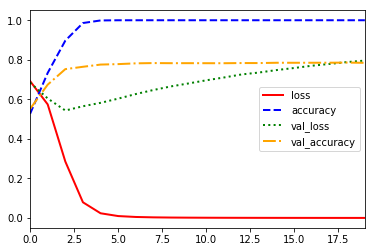

In [148]:
#plot epochs vs accuracy and loss
pd.DataFrame(history_w2v.history).plot(color=['red', 'blue', 'green', 'orange'], linewidth=2);

The best amount of epochs seems to be around 5, since the validation loss is fairly small here, while the validation accuracy is high. We will use this to train the final model.

In [43]:
#test accuracy & loss
start = time.time()
embedded_w2v_model.fit(padded_doc_tr, train_Y, epochs=5, batch_size=512, verbose=0)
result_w2v = embedded_w2v_model.evaluate(padded_doc_tt, test_Y, verbose = 0);
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result_w2v))
end = time.time()
print("time taken:", end - start)

Loss: 0.6631, Accuracy:  0.8131
time taken: 340.26997995376587


In [83]:
print("train accuracy = ",history_w2v.history['accuracy'][4])

train accuracy =  0.9993333


In [72]:
w2v_y_pred = embedded_w2v_model.predict(padded_doc_tt, verbose = 0)
w2v_y_pred = np.rint(w2v_y_pred)
confusion_matrix_w2v = confusion_matrix(test_Y, w2v_y_pred, labels=None, sample_weight=None)
print(confusion_matrix_w2v)

[[10144  2356]
 [ 2316 10184]]


In comparison to the untuned model from part 1, the model performs slightly worse. The model is somewhat overfitting, as the training accuracy is almost 1 and the test accuracy is significantly lower.

### Embedding 2 - Glove

In [45]:
# load the whole embedding into memory
embeddings_index_glove = dict()
f = open('glove.6B/glove.6B.300d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_glove[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index_glove))

Loaded 400000 word vectors.


In [46]:
weight_matrix_tr_glove = weight_matrix(embeddings_index_glove,vsize_tr, tokenizer_tr)

In [48]:
#Add glove embedding 
e_glove = Embedding(vsize_tr, 300,weights=[weight_matrix_tr_glove],input_length=max_length)

In [49]:
#these parameter settings are taken from the best model of part 1
embedded_glove_model = make_model(n_hidden=1, hidden_size = 8,
                       embedding=True, embedding_layer=e_glove, input_shape=(150000,))

In [50]:
embedded_glove_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          33661200  
_________________________________________________________________
flatten_1 (Flatten)          (None, 150000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2400016   
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 36,061,361
Trainable params: 36,061,361
Non-trainable params: 0
_________________________________________________________________


### Evaluation Glove

In [51]:
history_glove, train_acc_glove, val_acc_glove, train_loss_glove, val_loss_glove, epochs =\
scores(embedded_glove_model, nr_of_epochs, partial_x_train_embedding,partial_y_train_embedding, x_val_embedding, y_val_embedding)

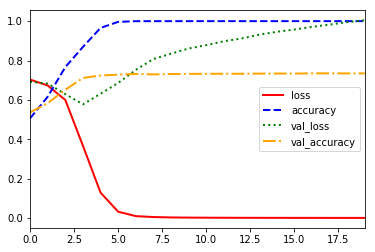

In [52]:
#plot epochs vs accuracy and loss
pd.DataFrame(history_glove.history).plot(color=['red', 'blue', 'green', 'orange'], linewidth=2);

The model seemingly starts to overfit from epoch 3, looking at the validation loss. The validation accuracy stagnates around epoch 3 and doesn't become any higher it seems. The training accuracy is still rising at the third epoch. Because it seems best when we look at the validation acuracy and loss, we will use 3 epochs to train the final model.

In [87]:
#test accuracy & loss
start = time.time()
embedded_glove_model.fit(padded_doc_tr, train_Y, epochs=3, batch_size=512, verbose=0)
result_glove = embedded_glove_model.evaluate(padded_doc_tt, test_Y, verbose = 0);
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result_glove))
end = time.time()
print("time taken:", end - start)

Loss: 0.8643, Accuracy:  0.7891
time taken: 249.96666717529297


In [94]:
print("train accuracy = ",history_glove.history['accuracy'][2])

train accuracy =  0.76666665


In [89]:
glove_y_pred = embedded_glove_model.predict(padded_doc_tt, verbose = 0)
glove_y_pred = np.rint(glove_y_pred)
confusion_matrix_glove = confusion_matrix(test_Y, glove_y_pred, labels=None, sample_weight=None)
print(confusion_matrix_glove)

[[9809 2691]
 [2582 9918]]


The model performs worse than the models from part 1 and also performoms worse than the the word2vec embedding. What stands out is that the test accuracy is higher than the training accuracy. We do not know why this effect occurs. 

### Embedding not pre-trained

In [54]:
e = Embedding(vsize, 100, input_length=max_length)
embedded_w2v_simple_model = make_model(n_hidden=1, hidden_size = 8,
                       embedding=True, embedding_layer=e, input_shape=(50000,)) # input_shape = max_length*output_dim embedding layer

In [55]:
embedded_w2v_simple_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                800016    
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 1,800,161
Trainable params: 1,800,161
Non-trainable params: 0
_________________________________________________________________


### Evaluation embedding not pre-trained

In [56]:
history_w2v_simple, train_acc_w2v_simple, val_acc_w2v_simple, train_loss_w2v_simple, val_loss_w2v_simple, epochs =\
scores(embedded_w2v_simple_model, nr_of_epochs, partial_x_train_embedding,partial_y_train_embedding, x_val_embedding, y_val_embedding)

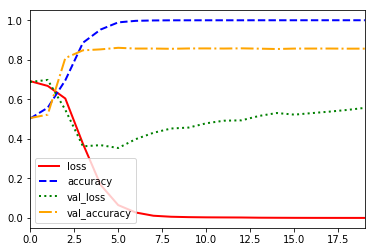

In [57]:
#plot
pd.DataFrame(history_w2v_simple.history).plot(color=['red', 'blue', 'green', 'orange'], linewidth=2);

When we look at the validation loss, the models seems to start overfitting from epoch 5 or 6. However when we look at the validation accuracy, it doesn't seem to start overfitting at all, since the validation accuracy stagnates at around 0.8. We will use 4 epochs, since the validation accuracy is at its highest here while the validation loss is at its lowest.

In [59]:
start = time.time()
embedded_w2v_simple_model.fit(padded_doc_tr, train_Y, epochs=4, batch_size=512, verbose=0)
result = embedded_w2v_simple_model.evaluate(padded_doc_tt, test_Y, verbose = 0);
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))
end = time.time()
print("time taken:", end - start)

Loss: 0.5221, Accuracy:  0.8482
time taken: 46.88496398925781


In [95]:
print("train accuracy = ",history_w2v_simple.history['accuracy'][3])

train accuracy =  0.88626665


In [96]:
simple_w2v_y_pred = embedded_w2v_simple_model.predict(padded_doc_tt, verbose = 0)
simple_w2v_y_pred = np.rint(simple_w2v_y_pred)
confusion_matrix_simple_w2v = confusion_matrix(test_Y, simple_w2v_y_pred, labels=None, sample_weight=None)
print(confusion_matrix_simple_w2v)

[[10809  1691]
 [ 2104 10396]]


The model performs slightly better than than the untuned model from part one, but not better than the tuned model. The model does not seem to over- or underfit. In the next part we will tune this model to see if we can further improve the model.

## 3. Tuning (20 points) {-}

### Word2Vec Tuning - Not pre-trained

In [126]:
regularizer_list = [regularizers.l2, regularizers.l1]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
optimizers = ['adam', 'rmsprop']

In [ ]:
#Grid search
opt_dict_emb = {}
for r in regularizer_list:
    for optimizer in optimizers:
        for lr in tqdm_notebook(learning_rates):
            model = make_model(n_hidden=n_hidden, hidden_size=hidden_size, input_size=16, 
                               optimizer=optimizer, regularizer=r(lr),
                               embedding = True, embedding_layer = e, input_shape=(150000,))
            
            opt_dict_emb[(r, optimizer, lr)] = NN_performance(model, partial_x_train_embedding, 
                                                              partial_y_train_embedding, 
                                                              x_val_embedding, 
                                                              y_val_embedding)

In [70]:
opt_df_emb = pd.DataFrame.from_dict(opt_dict_emb, orient='index') 

In [72]:
opt_df_emb

Max_val_acc  \
<function l2 at 0x12fd852f0> adam    1.00e-04         0.90   
                                     1.00e-03         0.90   
                                     1.00e-02         0.91   
                                     1.00e-01         0.93   
                             rmsprop 1.00e-04         0.89   
                                     1.00e-03         0.89   
                                     1.00e-02         0.89   
                                     1.00e-01         0.88   
<function l1 at 0x12fd79f28> adam    1.00e-01         0.80   
                                     1.00e-02         0.86   
                                     1.00e-03         0.87   
                                     1.00e-04         0.88   
                             rmsprop 1.00e-01         0.69   
                                     1.00e-02         0.84   
                                     1.00e-03         0.86   
                                     1.00e-04         0.87   

                                               Max_val_acc_epochs  \
<function l2 at 0x12fd852f0> adam    1.00e-04                   5   
                                     1.00e-03                  11   
                                     1.00e-02                   4   
                                     1.00e-01                   1   
                             rmsprop 1.00e-04                   2   
                                     1.00e-03                  10   
                                     1.00e-02                   8   
                                     1.00e-01                   8   
<function l1 at 0x12fd79f28> adam    1.00e-01                   2   
                                     1.00e-02                   2   
                                     1.00e-03                   2   
                                     1.00e-04                   2   
                             rmsprop 1.00e-01                   2   
                                     1.00e-02                   5   
                                     1.00e-03                   1   
                                     1.00e-04                   1   

                                               Min_val_loss  \
<function l2 at 0x12fd852f0> adam    1.00e-04          0.32   
                                     1.00e-03          0.27   
                                     1.00e-02          0.29   
                                     1.00e-01          0.47   
                             rmsprop 1.00e-04          0.34   
                                     1.00e-03          0.34   
                                     1.00e-02          0.34   
                                     1.00e-01          0.55   
<function l1 at 0x12fd79f28> adam    1.00e-01          9.28   
                                     1.00e-02          1.47   
                                     1.00e-03          0.52   
                                     1.00e-04          0.35   
                             rmsprop 1.00e-01         40.44   
                                     1.00e-02          4.61   
                                     1.00e-03          0.85   
                                     1.00e-04          0.42   

                                               Min_val_loss_epochs  train_time  
<function l2 at 0x12fd852f0> adam    1.00e-04                    1      178.36  
                                     1.00e-03                   11      183.38  
                                     1.00e-02                   20      182.14  
                                     1.00e-01                   20      182.43  
                             rmsprop 1.00e-04                    1      175.58  
                                     1.00e-03                    4      177.50  
                                     1.00e-02                   20      177.22  
                                     1.00e-01                   19      176.39  
<function l1 at 0

Interpreting the above gridsearch, the best regularizer is L2, with a learning rate of 1e-1. The best optimizer is adam, which is the default in our make_model function. The best amount of epochs for validation accuracy is 1, yet is 20 for validation loss. Therefore, we will plot the accuracy and loss distribution for 20 epochs.

In [154]:
#Making the optimized model
tuning_model = make_model(n_hidden=1, hidden_size = 8,
                       embedding=True, embedding_layer=e, input_shape=(50000,), regularizer =  regularizers.l2(1e-1)) # input_shape = max_length*output_dim embedding layer

In [155]:
history_tuning, train_acc_tuning, val_acc_tuning, train_loss_tuning, val_loss_tuning, epochs =\
scores(tuning_model, nr_of_epochs, partial_x_train_embedding,partial_y_train_embedding, x_val_embedding, y_val_embedding)

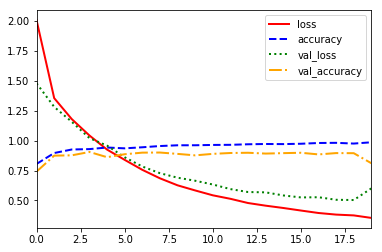

In [156]:
#plot
pd.DataFrame(history_tuning.history).plot(color=['red', 'blue', 'green', 'orange'], linewidth=2);

The model seems to have a very stable accuracy for both the training and the validation data. We will use 7 epochs to make the final model, the validation accuracy is quite high here, while the loss is fairly low. The number of epochs is not to high, which is important because of efficiency reasons. Increasing the amount of epochs would only increase fitting time.  

In [157]:
start = time.time()
tuning_model.fit(padded_doc_tr, train_Y, epochs=7, batch_size=512, verbose=0)
result = tuning_model.evaluate(padded_doc_tt, test_Y, verbose = 0);
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))
end = time.time()
print("time taken:", end - start)

Loss: 0.5320, Accuracy:  0.8497
time taken: 69.17920517921448


In [158]:
print("train accuracy = ",history_tuning.history['accuracy'][2])
print("train accuracy = ",history_tuning.history['val_accuracy'][2])

train accuracy =  0.92586666
train accuracy =  0.8771


In [159]:
tuning_y_pred = tuning_model.predict(padded_doc_tt, verbose = 0)
tuning_y_pred = np.rint(tuning_y_pred)
confusion_tuning = confusion_matrix(test_Y, tuning_y_pred, labels=None, sample_weight=None)
print(confusion_tuning)

[[10620  1880]
 [ 1878 10622]]


Adding L2 regularization with a learning rate of 1e-1 has a very minimal positive effect on the accuracy (0.8497 versus 0.8482). Next, we will tune the maximum length of the reviews.

### Tuning max_length

In [118]:
max_length_2 = 250
padded_doc_tr_2 = pad_sequences(encoded_docs_tr, maxlen =max_length_2, padding='post') #Turns every reviews in a review of max_length
padded_doc_tt_2 = pad_sequences(encoded_docs_tt, maxlen =max_length_2, padding='post')

In [160]:
e2 = Embedding(vsize, 100, input_length=max_length_2)
tuning_length = make_model(n_hidden=1, hidden_size = 8,
                       embedding=True, embedding_layer=e2, input_shape=(25000,), regularizer =  regularizers.l2(1e-1)) # input_shape = max_length*output_dim embedding layer

In [161]:
start = time.time()
tuning_length.fit(padded_doc_tr_2, train_Y, epochs=7, batch_size=512, verbose=0)
result = tuning_length.evaluate(padded_doc_tt_2, test_Y, verbose = 0);
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))
end = time.time()
print("time taken:", end - start)

Loss: 0.6630, Accuracy:  0.8425
time taken: 74.40125727653503


In [162]:
length_y_pred = tuning_length.predict(padded_doc_tt_2, verbose = 0)
length_y_pred = np.rint(length_y_pred)
confusion_length = confusion_matrix(test_Y, length_y_pred, labels=None, sample_weight=None)
print(confusion_length)

[[ 9697  2803]
 [ 1134 11366]]


The accuracy has slightly decreased by lowering the max length. We will further tune the max length by slightly increasing it.

In [178]:
max_length_3 = 625
padded_doc_tr_3 = pad_sequences(encoded_docs_tr, maxlen =max_length_3, padding='post') #Turns every reviews in a review of max_length
padded_doc_tt_3 = pad_sequences(encoded_docs_tt, maxlen =max_length_3, padding='post')

In [172]:
e3 = Embedding(vsize, 100, input_length=max_length_3)
tuning_length_2 = make_model(n_hidden=1, hidden_size = 8,
                       embedding=True, embedding_layer=e3, input_shape=(65000,), regularizer =  regularizers.l2(1e-1)) # input_shape = max_length*output_dim embedding layer

In [179]:
start = time.time()
tuning_length_2.fit(padded_doc_tr_3, train_Y, epochs=7, batch_size=512, verbose=0)
result = tuning_length_2.evaluate(padded_doc_tt_3, test_Y, verbose = 0);
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))
end = time.time()
print("time taken:", end - start)

Loss: 0.4536, Accuracy:  0.8491
time taken: 124.08481693267822


In [180]:
length_y_pred_2 = tuning_length_2.predict(padded_doc_tt_3, verbose = 0)
length_y_pred_2 = np.rint(length_y_pred_2)
confusion_length_2 = confusion_matrix(test_Y, length_y_pred_2, labels=None, sample_weight=None)
print(confusion_length_2)

[[10572  1928]
 [ 1844 10656]]


The accuracy has slightly decreased again, hence we will use max length = 500 for further tuning model. Next, we will tune the vocabulary size.

### Tuning Vocabulary size

In [144]:
print("Amount of unique words", round((vsize_tr+vsize_tt)/2))

Amount of unique words 111220


The amount of unique words is 111220, we will first try about half of this to see if the accuracy improves.

In [192]:
vsize = 50000
encoded_docs_tr_2 = [one_hot(d, vsize) for d in X_train2]
encoded_docs_tt_2 = [one_hot(d, vsize) for d in X_test2]

In [193]:
max_length_2 = 500
padded_doc_tr_2 = pad_sequences(encoded_docs_tr_2, maxlen =max_length_2, padding='post') #Turns every reviews in a review of max_length
padded_doc_tt_2 = pad_sequences(encoded_docs_tt_2, maxlen =max_length_2, padding='post')

In [194]:
e2 = Embedding(vsize, 100, input_length=max_length_2)
tuning_vsize = make_model(n_hidden=1, hidden_size = 8,
                       embedding=True, embedding_layer=e2, input_shape=(5000000,), regularizer =  regularizers.l2(1e-1)) # input_shape = max_length*output_dim embedding layer

In [195]:
start = time.time()
tuning_vsize.fit(padded_doc_tr_2, train_Y, epochs=7, batch_size=512, verbose=0)
result = tuning_vsize.evaluate(padded_doc_tt_2, test_Y, verbose = 0);
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))
end = time.time()
print("time taken:", end - start)

Loss: 0.6094, Accuracy:  0.8644
time taken: 114.11395382881165


In [196]:
vsize_y_pred = tuning_vsize.predict(padded_doc_tt_2, verbose = 0)
vsize_y_pred = np.rint(vsize_y_pred)
confusion_vsize = confusion_matrix(test_Y, vsize_y_pred, labels=None, sample_weight=None)
print(confusion_vsize)

[[10659  1841]
 [ 1548 10952]]


The accuracy has slightly improved, we will further increase the vocabulary size to see if we can further improve the model.

In [186]:
vsize = 100000
encoded_docs_tr_2 = [one_hot(d, vsize) for d in X_train2]
encoded_docs_tt_2 = [one_hot(d, vsize) for d in X_test2]

In [187]:
max_length_2 = 500
padded_doc_tr_2 = pad_sequences(encoded_docs_tr_2, maxlen =max_length_2, padding='post') #Turns every reviews in a review of max_length
padded_doc_tt_2 = pad_sequences(encoded_docs_tt_2, maxlen =max_length_2, padding='post')

In [188]:
e2 = Embedding(vsize, 100, input_length=max_length_2)
tuning_vsize_2 = make_model(n_hidden=1, hidden_size = 8,
                       embedding=True, embedding_layer=e2, input_shape=(5000000,), regularizer =  regularizers.l2(1e-1)) # input_shape = max_length*output_dim embedding layer

In [189]:
start = time.time()
tuning_vsize_2.fit(padded_doc_tr_2, train_Y, epochs=7, batch_size=512, verbose=0)
result = tuning_vsize_2.evaluate(padded_doc_tt_2, test_Y, verbose = 0);
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))
end = time.time()
print("time taken:", end - start)

Loss: 0.6728, Accuracy:  0.8439
time taken: 201.9387927055359


In [198]:
vsize_y_pred = tuning_vsize.predict(padded_doc_tt_2, verbose = 0)
vsize_y_pred = np.rint(vsize_y_pred)
confusion_vsize = confusion_matrix(test_Y, vsize_y_pred, labels=None, sample_weight=None)
print(confusion_vsize)

[[10659  1841]
 [ 1548 10952]]


The accuracy has now slighlty decreased again. Therefore, we will use vocabulary size = 50000 for the final model. The final model model will thus have the following hyperparameters:
- hidden layers: 1
- hidden layer size: 8
- regularization: L2
- learning rate: 1e-1
- Epochs: 7
- vocabulary size: 50000
- max length: 500

This model yields 0.8644 accuracy. In comparison, the untuned embedded model yielded 0.8482 and the tuned model from part 1 yielded 0.8779 accuracy. Overall, tuning the embedded model had almost no effect on accuracy. In addition, the final model has a bigger fitting time and more parameters to train. This could provide issues when the size of the data-set increases. Therefore, it might be better to use the original embedded model over the tuned one when the size of the data-set increases. Furthermore, adding the embedding layer did not have a positive effect on the model from part one. A possible explanation for this could be that the words are integer encoded in part one using TF-IDF and using one-hot encoding in part two and three. Using the TF-IDF encoding in the embedding might further increase performance.

## 4. Transfer learning (30 points) {-}

### Extract the output of the training and test data from the 4th layer

In [ ]:
# Get output of train/test data of the fourth layer in a Sequential model by using keras backend
get_4rd_layer_output_test = K.function([embedded_w2v_simple_model.layers[0].input],
                                  [embedded_w2v_simple_model.layers[3].output])

layer_output_train = get_4rd_layer_output_test(padded_doc_tr)[0]

start3= time.time()
layer_output_test = get_4rd_layer_output_test(padded_doc_tt)[0]
end3 = time.time()
time_taken_fitting_test_untill_4th_layer = end3-start3

### Evaluation metrics
The evaluation metrics which are used to evaluate the models are time and the test score (accuracy). As can be seen in the evaluation of the KNN, the AUC score has been applied aswell. The reason for trying to use the AUC score is that solely basing the performance of the models on accuracy might be trivial, since accuracy works with a certain treshold. The AUC score provides means as an evaluation metric, without being influenced by imbalances of datasets. The accuracy is effected by the imbalancedness of the datasets, in contrary to the AUC score. However, after trying the AUc score, we concluded that the scores are almost the same as the ones from the accuracy scores. A possible reason for this is that our data is perfectly balanced. For this reason, we've only applied the AUC score for evaluation of the KNN and for the others we solely use the speed and accuracy.

### Logistic Regression

#### Motivation
The choice to include Logistic Regression is that this algorithm performs generally well with multi dimensional data. Since our new representation of the dataset has multiple values for one x, it can be concluded than many dimensions exits. Also, the outcomes of our dataset are limited and binary, either 0 or 1. Logistic Regression produces outcomes which have only a limited number of possible values, in contrary to Linear Regression. Hence logistic regression is included.


In [63]:
#Create a first model to see how it performs without any hyperparameter tuning
def logistic_regression_scores(penalty='l2', solver='liblinear', c=1):
    lr = LogisticRegression()
    start = time.time()
    lr.fit(layer_output_train, train_Y)
    test_score = 'test score: ' + str(lr.score(layer_output_test, test_Y))
    train_score = 'train score: ' + str(lr.score(layer_output_train, train_Y))
    end = time.time()
    time_taken = 'time taken: ' + str(end-start)
    return(train_score, test_score, time_taken)

In [64]:
logistic_regression_scores()

('train score: 0.99032',
 'test score: 0.85828',
 'time taken: 0.055879831314086914')

As can be seen above, the accuracy, without tuning, is 0.005 higher than the accuracy of the Neural network from part 2 (which is 0.8535). The hyperparameters will be further tuned in order to see if a higher accuracy can be obtained. Also, the algorithm is fast. It takes less than a second to run.

#### Random Search
To find better hyperparamters, RandomSearch is chosen. Since we do not have an idea of what the grid of optimal hyperparameters could be, we don't use GridSearch here, but RandomSearch. Hyperparameters to optimize are: C value, and the penalty. To limit the running time of the RandomSearch, the number of samples and the population of the C is kept low. A solver coul be added too, however, certain penalties do not work with certain solvers and vice versa. Hence the solvers are excluded in this random search.

In [66]:
# specify parameters and distributions to sample from

lr = LogisticRegression()
param_dist_svm = {"C": np.random.randint(0, 20, 5),
              "penalty": ['l1', 'l2', 'elasticnet']} # 'none' is excluded since default solver can't handle that penalty.

# run randomized search
n_iter_search = 1
random_search_lr = RandomizedSearchCV(lr, param_distributions=param_dist_svm,
                                   n_iter=n_iter_search, cv=3, iid=False)

start = time.time()
random_search_lr.fit(layer_output_test, test_Y)
end = time.time()
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((end - start), n_iter_search))

print(random_search_lr.best_score_)
random_search_parameters_lr = random_search_lr.best_params_

RandomizedSearchCV took 0.56 seconds for 1 candidates parameter settings.
0.8613602702470312


In [92]:
random_search_parameters_lr

{'penalty': 'l1', 'C': 14}

In [70]:
logistic_regression_scores(random_search_parameters_lr['penalty'], random_search_parameters_lr['C'])

('train score: 0.99032',
 'test score: 0.85828',
 'time taken: 0.053394317626953125')

#### Interpretation
The accuracy, obtained when putting the results, which are the optimal hyperparameters, from the RandomSearch in the logisticregression model, is the same as the accuracy of the first try with logistic regression. From this we can conclude that the random search did not find a better accuracy by using random search. More options could be included in the hyperparameter parameters. Also, more hyperparameters could be included into the randomsearch, such as a solver. This could improve the accuracy. Also, trying more iterations would probably increase the test score slightly, since more (random) points will be selected in the RandomSearch. 
However, this algorithm provides an accuracy that is quite close to the one from the NeuralNetwork, which is 0.8535. LogisticRegression is really fast for this dataset, less than a second. Which should be conisdered if other models are not able to incrase the accuracy significantly.

The model seems to be overfitting, since the trainscore is almost 1 and the test score is 0.15 lower. Maybe a simpler version of this model could be created in order to battle overfitting. However, according to our randomsearch, the model's train and test score do not change. 

### Support Vector Machine
the second model is based on a support vector machine. The reason for choosing this algorithm is that it scales relatively well to high dimensional data. Furthermore, different kernels can be used to classify data, which is a major advantage of the SVM. Finally, SVMs provide regularization parameters. Which enables us to tweak the model if it tends to overfit on the data.

In [59]:
#Create function to see the scores of the SVC model with certain hyperparameters
def svc_scores(c=1, kernel='rbf', gamma='auto'):
    clf = SVC(C=c, kernel=kernel, gamma=gamma)
    start = time.time()
    clf.fit(layer_output_train, train_Y)
    test_score = 'test score: ' + str(clf.score(layer_output_test, test_Y))
    train_score = 'train score: ' + str(clf.score(layer_output_train, train_Y))
    end = time.time()
    time_taken = 'time taken: ' + str(end-start)
    return(train_score, test_score, time_taken)

In [25]:
#Test without any selection of hyperparameters but the defaults
svc_scores()

('train score: 0.9984', 'test score: 0.8474', 'time taken: 0.5065438747406006')

The accuracy score from the NeuralNetwork is 0.8535. This is higher than the first try, which is 0.847. The difference is only 0.05. The algorithm is slower than the logistic regression, however, it is still below one second. Maybe if hyperparameters are tuned, a better accuracy could be achieved.

#### Random Search
To find better hyperparameters, RandomSearch is chosen. Since we do not have an idea of what the grid of optimal hyperparameters could be, we don't use GridSearch here, but RandomSearch. Hyperparameters to optimize are: C value, Kernel, and Gamma. To limit the running time of the RandomSearch, the number of samples and the population of the C and Gamma are decreased to 5 samples out of range 0 to 20. All kernels have been included as parameters for the randomsearch

In [50]:
# specify parameters and distributions to sample from

svc = SVC()
param_dist_svm = {"C": np.random.randint(0, 20, 5),
              "kernel": ['rbf', 'linear', 'poly'],
              "gamma": np.random.randint(0, 20, 5)}

# run randomized search
n_iter_search = 1
random_search = RandomizedSearchCV(svc, param_distributions=param_dist_svm,
                                   n_iter=n_iter_search, cv=3, iid=False)

start = time.time()
random_search.fit(layer_output_test, test_Y)
end = time.time()
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((end - start), n_iter_search))

RandomizedSearchCV took 280.89 seconds for 1 candidates parameter settings.


In [54]:
random_search.best_params_

{'kernel': 'rbf', 'gamma': 3, 'C': 11}

In [98]:
print(random_search.best_score_)
random_search_parameters_svc = random_search.best_params_

svc_scores(random_search_parameters_svc['C'],random_search_parameters_svc['kernel'], random_search_parameters_svc['gamma'])

0.8610402670426788


('train score: 0.99056', 'test score: 0.859', 'time taken: 1.3439998626708984')

#### Interpretation
The results from the randomsearch state that the rbf kernel with a gamma of 3 and a C value of 11. By inserting these parameters into the SVM, an test score of  0.859 is obtained. This is higher than the first try without the hyperparameter tuning, namely 0.8474. The test accuracy of the SVM with parameter tuning is slightly higher than the one from the NeuralNetwork, higher by 0.012. Which is almost insignificant. 

The model tends to overfit, since the test score is almost equal to 1. This indicates that the model predicts the training data almost perfectly, while predicting the test data is not as good. The parameters have been tuned to decrease the overfitting, however, the results is quite low.

Also, it took 280 seconds, which is almost 5 minutes, to run the randomsearch. More values can be included to the randomsearch for each hyperparameter and the number of iterations could be increased in order to increase the test score. However, since the randomsearch requires quite the computational power, this has not been done.  

### KNN

The third machine learning algorithm is K nearest neighbors. The reason for this choice is that KNN is easy to implement and robust regarding the search space. For example, classes don't have to be lineary seperable. Also, this algorithm does not have many hyperparameters, which makes it easy to tune it. Furthermore, since KNN does not perform well with imbalanced datasets in general, this dataset is well suited for this algorithm since it is extremely balanced.

In [97]:
#KNN
def knn_scores(n_neighbors=5, p=2):
    """n_neighbors is the number of neighbors you would like to insert into the model. in sklearn 5 is default
        p is the power parameter for the Minkowski metric. in sklearn 2 is default"""  
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
    start = time.time()
    knn.fit(layer_output_train, train_Y)

    test_score = 'test score: ' + str(knn.score(layer_output_test, test_Y))
    train_score = 'train score: ' + str(knn.score(layer_output_train, train_Y))
    end = time.time()
    time_taken = 'time taken: ' + str(end-start)
    print(train_score, test_score, time_taken)

#Create first model without parameter tuning to see how it performs
knn_scores(3)

train score: 0.99284 test score: 0.8558 time taken: 0.622960090637207


The test score is higher than the test score from the Neural Network, which is 0.8535. However, tuning the parameters (k neigbors and the p value) might increase the accuracy more. The speed of training this model is quite fast. It is slower than the logistic regression but faster than the SVM 

max accuracy: 0.85932


Text(0,0.5,'Accuracy')

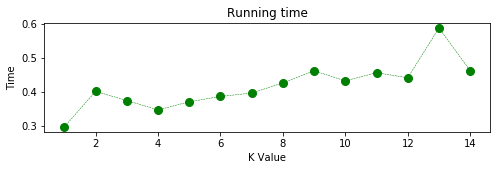

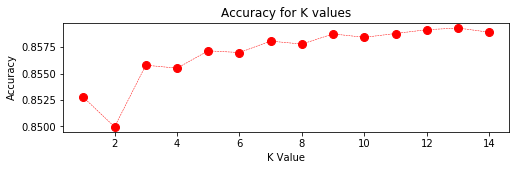

In [99]:
#trying to tune the K value and plot the results:
accuracy = []
time_taken = []

# Calculating accuracy for K values between 1 and 15
range_number = 15
for i in range(1, range_number):  
    #make model
    knn = KNeighborsClassifier(n_neighbors=i)

    # Train the classifier
    start = time.time()
    knn.fit(layer_output_train, train_Y)
    pred_i = knn.predict(layer_output_test)
    end = time.time()
    accuracy.append(knn.score(layer_output_test, test_Y))
    time_taken.append(end-start)

plt.figure(figsize=(8, 2))  
plt.plot(range(1, range_number), time_taken, color='green', linestyle='dashed', marker='o',  
         markerfacecolor='green', markersize=8)
plt.title('Running time')  
plt.xlabel('K Value')  
plt.ylabel('Time') 

print('max accuracy: ' + str(max(accuracy)))
plt.figure(figsize=(8, 2)) 
plt.plot(range(1, range_number), accuracy, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='red', markersize=8)
plt.title('Accuracy for K values')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy') 

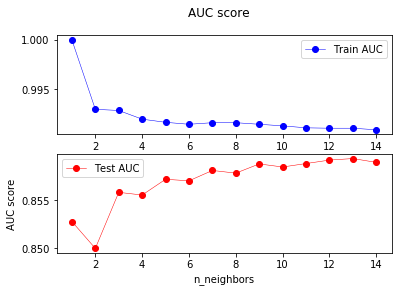

In [102]:
#AUC score for every k value, plot these results
train_results = []
test_results = []

range_number = 15
for n in range(1, range_number):
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(layer_output_train, train_Y)
    train_pred = model.predict(layer_output_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_Y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(layer_output_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_Y, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

fig, (axs0, axs1) = plt.subplots(2)
fig.suptitle('AUC score')
axs0.plot(range(1, range_number), train_results, 'b', marker='o', label= 'Train AUC')
axs0.legend()
axs1.plot(range(1, range_number), test_results, 'r', marker='o', label= 'Test AUC')
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
axs1.legend()
plt.show()

max accuracy: 0.85792


Text(0,0.5,'Accuracy')

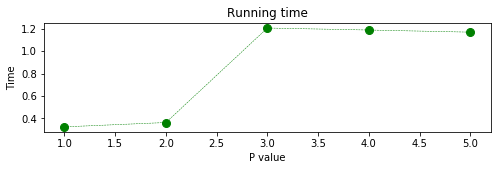

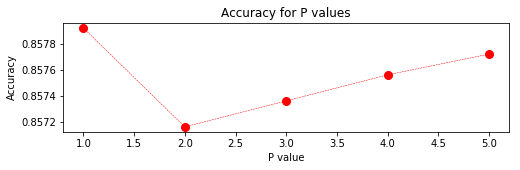

In [40]:
#trying to tune the p value and plotting the results in a graph:
accuracy = []
time_taken = []

# Calculating error for p values between 1 and 5
range_number = [1, 2, 3, 4, 5]
for i in range_number:  
    #make model
    knn = KNeighborsClassifier(p=i)

    # Train the classifier
    start = time.time()
    knn.fit(layer_output_train, train_Y)
    pred_i = knn.predict(layer_output_test)
    end = time.time()
    accuracy.append(knn.score(layer_output_test, test_Y))
    time_taken.append(end-start)

plt.figure(figsize=(8, 2))  
plt.plot(range_number, time_taken, color='green', linestyle='dashed', marker='o',  
         markerfacecolor='green', markersize=8)
plt.title('Running time')  
plt.xlabel('P value')  
plt.ylabel('Time') 

print('max accuracy: ' + str(max(accuracy)))
plt.figure(figsize=(8, 2)) 
plt.plot(range_number, accuracy, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='red', markersize=8)
plt.title('Accuracy for P values')  
plt.xlabel('P value')  
plt.ylabel('Accuracy') 

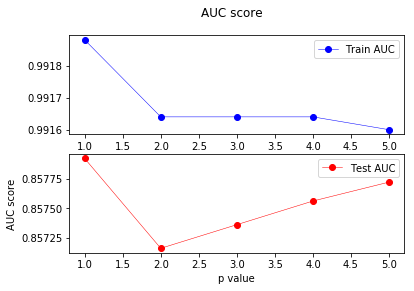

In [41]:
#AUC score for each p value, plotting the results in a graph:
distances = [1, 2, 3, 4, 5]
train_results = []
test_results = []

for p in distances:
    model = KNeighborsClassifier(p=p)
    model.fit(layer_output_train, train_Y)
    train_pred = model.predict(layer_output_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_Y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = model.predict(layer_output_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_Y, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

fig, (axs0, axs1) = plt.subplots(2)
fig.suptitle('AUC score')
axs0.plot(distances, train_results, 'b', marker='o', label='Train AUC')
axs0.legend()
axs1.plot(distances, test_results, 'r', marker='o', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('p value')
axs1.legend()
plt.show()    

In [101]:
#Take the k value with the highest accuracy and lowest mean error and optimal AUC score for the p value, 
#according to the graphs above
knn_scores(13)
knn_scores(p=1)
knn_scores(13, 1)

train score: 0.99104 test score: 0.85932 time taken: 0.7966029644012451
train score: 0.99188 test score: 0.85792 time taken: 0.5485329627990723
train score: 0.99108 test score: 0.85868 time taken: 0.7101001739501953


#### Interpretation KNN
When searching for the optimal hyperparameters for KNN, two approaches have been executed. Firstly, the n_neigbors has been altered. A range of 15 has been examined. The optimal number of neighbors is, according to the accuracy in the graph, 13. However, only using accuracy as evaluation might be trivial. AUC scores have been implemented in order to check for the optimal hyperparameters. However, these generate the same outcomes as the accuracy, namely 13 neigbors. This could be since the dataset is perfectly balanced and AUC score provides more accurate results when the dataset is imbalanced, opposed to the accuracy. Implementing this hyperparameter in a new KNN model yields an accuracy of 0.85932. Which is 0.006 higher than the accuracy of the Neural Network with Embedding. Also, the running time for 13 neigbors is amoung the highest running times.


The second parameter, which is to be altered, is the power parameter for the Minkowski metric. The slope of the accuracy and AUC score is decreasing while the p increases. Hence a p of 1 provides the best accuracy. P of 1 is also known as the manhattan_distance. However, when solely using the optimal p value of 1, the test accuracy is 0.85792, which is 0.002 higher than the accuracy score of the Neural Network. Combining both the optimal n_neighbors and p value gives the value of 0.85868. This shows that both optimal points do not necessarily provide the best scores together. Which is the case.

In all cases, the KNN model is overfitting, since the train accuracy is close to 1, which indicates that it is perfectly predicting the training data. However, the test accuracy is around 0.86. This difference means that the model is overfitting on the train data. 

From these results can be concluded that the KNN is slightly better able to classify the test data than the Neural network. However, the difference is too small to be noticed in the predictions. Which leads to the conclusion that KNN is not significantly better to predict than the neural network model.

### Random Forest

The final model that has been included is RandomForest. This model has been chosen since it has many parameters to tune, which could lead to a higher accuracy. Furthermore, this model is easy to execute and it is, in general, quite fast.

In [89]:
def random_forest_scores(criterion='gini',  max_depth=None, min_samples_split=2, max_features='auto',
                               bootstrap=True):
    rf = RandomForestClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, 
                                max_features=max_features, bootstrap=bootstrap)
    start = time.time()
    rf.fit(layer_output_train, train_Y)
    test_score = 'test score: ' + str(rf.score(layer_output_test, test_Y))
    train_score = 'train score: ' + str(rf.score(layer_output_train, train_Y))
    end = time.time()
    time_taken = 'time taken: ' + str(end-start)
    return(train_score, test_score, time_taken)

In [93]:
#First creation of a randomforest without tuning any parameters
random_forest_scores()

('train score: 0.99872', 'test score: 0.8552', 'time taken: 0.277569055557251')

The test score is 0.8552, which is higher than the NeuralNetwork's score of 0.8535. Furthermore, the time taken is quite low, less than one second. The first model is faster than the KNN and the SVM, but slower than the logistic regression

#### RandomSearch
To find better hyperparameters, RandomSearch is chosen. Since we do not have an idea of what the grid of optimal hyperparameters could be, we don't use GridSearch here, but RandomSearch. Hyperparameters to optimize are: max_depth, max_features, min_samples_split, bootstrap, and the criterion. To limit the computational intensity of this randomsearch, not all possible parameter values have been included.

In [77]:
rf = RandomForestClassifier()
param_dist_svm = {"max_depth": [3, None],
              "max_features": np.random.randint(1, 8, 6), #The max amount of features is 8, since our dataset has 8 features
              "min_samples_split": np.random.randint(2, 8, 6), #2 is the minimum of a split, hence it starts at 2
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 1
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_svm,
                                   n_iter=n_iter_search, cv=3, iid=False)

start = time.time()
random_search_rf.fit(layer_output_test, test_Y)
end = time.time()
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((end - start), n_iter_search))

print(random_search_rf.best_score_)
random_search_parameters_rf = random_search_rf.best_params_

RandomizedSearchCV took 2.36 seconds for 1 candidates parameter settings.
0.8373999787170172


In [80]:
random_search_parameters_rf

{'min_samples_split': 3,
 'max_features': 2,
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': False}

In [90]:
random_forest_scores(random_search_parameters_rf['criterion'], random_search_parameters_rf['max_depth'], 
                     random_search_parameters_rf['min_samples_split'], random_search_parameters_rf['max_features'], 
                     random_search_parameters_rf['bootstrap'] )

('train score: 1.0', 'test score: 0.85628', 'time taken: 0.502974271774292')

##### Adding number of estimators (1000) as extra parameter
Another tuning option, which has been included, is the adding number of estimators=1000. Increasing N_estimators means increasing the number of trees in th eforest. Usually, the thigher the number of trees, the better the data is learned. However, adding many more trees will slow down the training process

In [94]:
rf = RandomForestClassifier(n_estimators=1000)
param_dist_svm = {"max_depth": [3, None],
              "max_features": np.random.randint(1, 8, 6), #The max amount of features is 8, since our dataset has 8 features
              "min_samples_split": np.random.randint(2, 8, 6), #2 is the minimum of a split, hence it starts at 2
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 1
random_search_rf_estimators = RandomizedSearchCV(rf, param_distributions=param_dist_svm,
                                   n_iter=n_iter_search, cv=3, iid=False)

start = time.time()
random_search_rf_estimators.fit(layer_output_test, test_Y)
end = time.time()
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((end - start), n_iter_search))

print(random_search_rf_estimators.best_score_)
random_search_parameters_rf_estimators = random_search_rf_estimators.best_params_

RandomizedSearchCV took 192.53 seconds for 1 candidates parameter settings.
0.8545198765279766


In [95]:
random_search_parameters_rf_estimators

{'min_samples_split': 6,
 'max_features': 4,
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': True}

In [96]:
random_forest_scores(random_search_parameters_rf_estimators['criterion'], random_search_parameters_rf_estimators['max_depth'], 
                     random_search_parameters_rf_estimators['min_samples_split'], random_search_parameters_rf_estimators['max_features'], 
                     random_search_parameters_rf_estimators['bootstrap'] )

('train score: 0.99744',
 'test score: 0.85764',
 'time taken: 0.4243755340576172')

#### Interpretation
The randomsearch states that the combination of: min_samples_split=3, max_features=2, max_depth=None, criterion=entropy, and bootstrap=False, yields the best test score. The test score is 0.85628, which is slightly higher than the test score (0.8552) obtained without tuning. Only 0.001 higher to be precise. This indicates that the tuning did improve the accuracy. However, the increase is insignificant. The accuracy of the tuned model is higher than the test score of the NeuralNetwork, which is 0.8535. 

Another randomsearch has been executed with the addition of having n_estimators=1000. The best combination, obtained via the RandomSearch, consists of: min_samples_split=6, max_features=4, max_depth=None, criterion=entropy, and bootstrap=True. This hyperparameter combinations provides a test score of 0.85764, which is both higher than the accuracy of the model without tuning and the tuned model without n_estmators=100. The test score of the final random forest model is 0.004 higher than the accuracy of the Neural Network. 

After tuning, the model is still overfitting a bit, since the training score is almost perfect and the test score is around 0.14 lower. Hence tuning the hyperparameters did not combat the overfitting.

Possibly, a better hyperparameter combination could be achieved by increasing the number of iterations and/or increasing the (samples of) parameter values for min_samples_split, max_features, and max_depth. However, the increase in the model's accuracy might still be insignificant.

### Conclusion
    Accuracy (test score)
    Neural network:      0.8535
    logistic regression: 0.85828  
    SVM:                 0.85524
    KNN:                 0.85932
    Random forests:      0.85764
    
    Time taken (fit&predict)
    logistic regression: 0.053394317626953125  
    SVM:                 1.3439998626708984
    KNN:                 0.7966029644012451
    Random forests:      0.4243755340576172

From the numbers above can be derived that the KNN has the best test score from all models. However, the differences between all models are significantly low, since the differences are 0.00X.

All the models are overfitting, even after tuning the hyperparameters (regularization) to lower the distances between the test and training scores. All the models have an almost perfect training score. A likely explanation for this could be that the neural network already changed the original data in such way that predicting the training data is easy for the other machine learning models, which gives the high training scores. 

When looking at the training time, bigger differences can be derived. The logistic regression is by far the fastest model created as part of transfer learning. It probably is faster than the final layer of the Neural Network (which is an assumption, since we were not able to measure the speed). If the aim is to build a fast, low training time that is, model, then one should consider using a logistic regression as part of transfer learning with a Neural Network. 

Creating these models and tuning all the parameters is a lot of work and quite time and computational consuming. The improvements in accuracy are too insignificant for this dataset. In real life, it would take too much time for this small improvement, an improvement you would probably not even notice when prediciting whith that model. A lot of time, which translates to a lot of hourly wages (costs), have been invested in trying to improve the neural network with other models.

More tuning could have been done in order to try to obtain better results (faster models/better accuracy). Also, the randomsearch takes random points. This does not have to mean that these points are the best points to be taken. Points being hyperparameters in our case. Different models could have been created in order to check if those are able to predict better, however, this is not done in this assignment due to time constraints.

Instead of RandomSearch, bayesian optimization could have been applied to find the optimal hyperparameters for the models. Bayesian optimization is able to combine multiple parameter combinations by using a surrogate model and acquisition function to predict the best outcomes. Because this was part of the previous assignment, which has not been graded yet, hence no feedback provided, bayesian optimization has not been included to prevent using code that does not work properly. 

To conclude. If a fast model is of great importance, one could consider to implement the logistic regression. Since the test scores are, for all models, almost the same, the accuracy differences are not significantly important enough. If time is related to costs, then we would recommend not to try to tune models, such as KNN/RandomForest/LogisticRegression/SVM, for this dataset. This because it is quite time consuming to find only slight improvements by tuning the hyperparameters of the models.


*Food for thought:*

Because the assignment stated that we should use the embedded models, we used the best embedded neural network. However, this was not the model with the best accuracy in the assignment. If we would've used the best neural network from assignment one with the tfidf-vectorized data, assignment 4 might've also yielded better results.

## General notes on the assignment
As can be seen that the tuning of hyperparameters (in part 3 and 4) provides minor improvements, adding more data could be beneficial. As many features are used, more data (exponentially more data) will often yield better results, since you are trying to avoid sparseness. 

## 5. Bonus (5 points) {-}
We think that we went 'above and beyond' in this assignment since we've tried many things to obtain the best model: 

In part 2 we have tried three different embeddings and looked at the difference between one-hot-encoding and the tokenizer text-to-sequence function. One-hot-encoding provided a significant higher accuracy than the latter. This shows that we tried more than was demanded in the assignment. Furthermore, 4 models have been evaluated for transfer learning to check if one would perform better than. 